# Combining ISEAR and GoEmotions: Handling Class Imbalance with SMOTE

This Colab notebook builds on the combined ISEAR and GoEmotions dataset to address the **class imbalance problem** in emotion classification. By applying the **Synthetic Minority Oversampling Technique (SMOTE)**, we balance the dataset and evaluate the performance of various classifiers on the resampled data.

### Key Highlights:
1. **Dataset Preparation:**
   - Load the combined dataset.
   - Visualize class distributions before and after applying SMOTE.

2. **Feature Engineering:**
   - Use TF-IDF Vectorizer to convert text data into numerical features suitable for model training.

3. **Handling Class Imbalance:**
   - Apply SMOTE to oversample minority classes in the training data.
   - Visualize the class distribution post-resampling.

4. **Model Training and Evaluation:**
   - Train four classifiers:
     - Logistic Regression
     - Naive Bayes
     - Decision Tree
     - Random Forest
   - Evaluate performance using:
     - Accuracy
     - Classification Report
     - Confusion Matrix

5. **Accuracy Comparison:**
   - Visualize and compare model accuracies after applying SMOTE.

This notebook demonstrates how to integrate SMOTE into a machine learning pipeline for better performance on imbalanced datasets.


# Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Step 2: Load the combined dataset

In [2]:
combined_df = pd.read_csv('/content/Combined_Emotion_Dataset.csv')

# Check for any null values in the dataset
print("\n--- Null Values in Combined Dataset ---")
print(combined_df.isnull().sum())


--- Null Values in Combined Dataset ---
EMOTION         0
cleaned_text    0
dtype: int64


<ipython-input-3-f70d84a7ee8c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=combined_df, x='EMOTION', order=combined_df['EMOTION'].value_counts().index, palette='viridis')


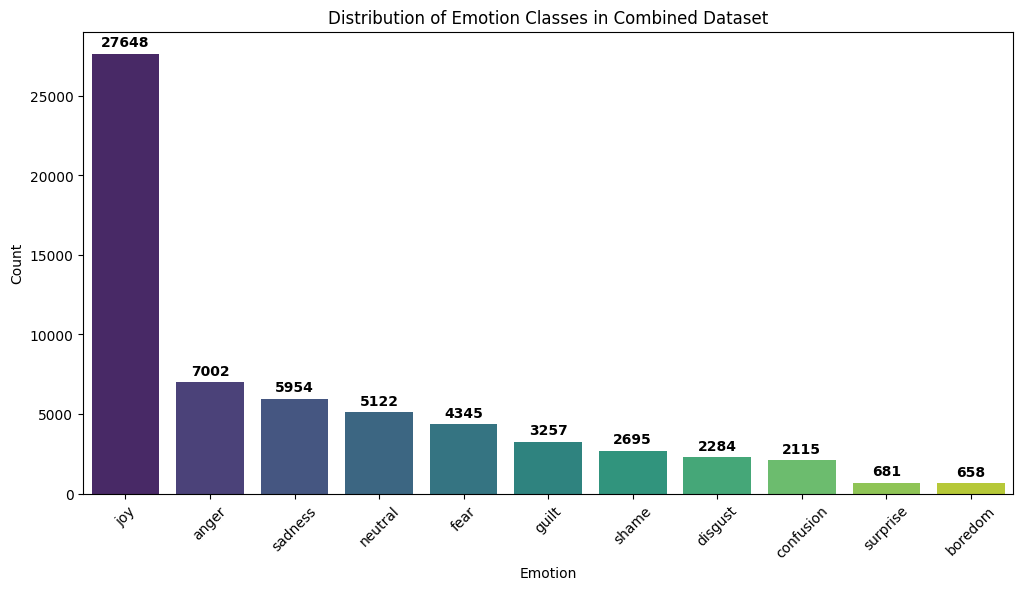

In [3]:
# Plotting the distribution of classes in the combined dataset with count labels
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=combined_df, x='EMOTION', order=combined_df['EMOTION'].value_counts().index, palette='viridis')
plt.title("Distribution of Emotion Classes in Combined Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Adding count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 8),
                textcoords = 'offset points',
                fontsize=10, color='black', weight='bold')

plt.show()


# Step 3: Split the Data into Train and Test Sets

In [4]:
# Assuming `combined_df` is the dataframe with columns 'EMOTION' and 'cleaned_text'
X = combined_df['cleaned_text']
y = combined_df['EMOTION']

# Split into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 4: Text Vectorization using TF-IDF

In [5]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Fit and transform the train set, transform the test set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Step 5: Handle Class Imbalance using Oversampling techniques (SMOTE)

## Define Resampling and Evaluation Functions

In [6]:
def apply_resampling(X, y):
    smote = SMOTE(random_state=42)

    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Plot the class distribution after resampling
    class_counts = pd.Series(y_resampled).value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title(f"Class Distribution after SMOTE")
    plt.xlabel("Classes")
    plt.ylabel("Count")

    # Adding labels to bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    plt.show()

    return X_resampled, y_resampled

# Step 6: Train and Evaluate Models after applying resampling techniques

### Emotion Labels

In [7]:
# Define emotion labels as unique values from the 'EMOTION' column
emotion_labels = combined_df['EMOTION'].unique()

# Convert the array to a list (optional, based on your use case)
emotion_labels_list = emotion_labels.tolist()

# Print the defined emotion labels
print("Defined Emotion Labels:")
print(emotion_labels_list)


Defined Emotion Labels:
['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt', 'boredom', 'surprise', 'neutral', 'confusion']


##Function for Training, Evaluating, and Plotting Confusion Matrix

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate and print accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- {model_name} with SMOTE ---")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix with diagonal highlighted
    plot_confusion_matrix(y_test, y_pred, model_name)
    return accuracy


## Function for Confusion Matrix Plotting with Diagonal Highlighted

In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    # Create a mask for the diagonal
    mask = np.eye(*cm.shape, dtype=bool)

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels, cbar=False)

    # Overlay diagonal elements with a different color
    for i in range(cm.shape[0]):
        plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='orange', lw=2))

    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## Prepare Data and Apply Resampling Techniques


<ipython-input-6-f35b4407941c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


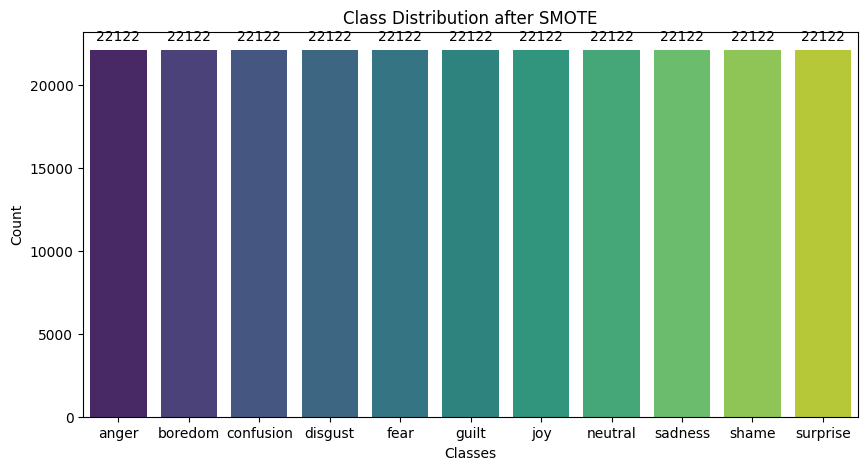


--- Logistic Regression with SMOTE ---
Accuracy: 0.4222456083542459
Classification Report:
               precision    recall  f1-score   support

       anger       0.53      0.46      0.50      1403
     boredom       0.26      0.70      0.38       124
   confusion       0.16      0.37      0.23       438
     disgust       0.24      0.47      0.32       451
        fear       0.30      0.34      0.32       839
       guilt       0.20      0.27      0.23       690
         joy       0.66      0.42      0.51      5526
     neutral       0.56      0.62      0.59      1018
     sadness       0.36      0.37      0.37      1172
       shame       0.22      0.33      0.26       572
    surprise       0.18      0.58      0.28       120

    accuracy                           0.42     12353
   macro avg       0.34      0.45      0.36     12353
weighted avg       0.50      0.42      0.44     12353



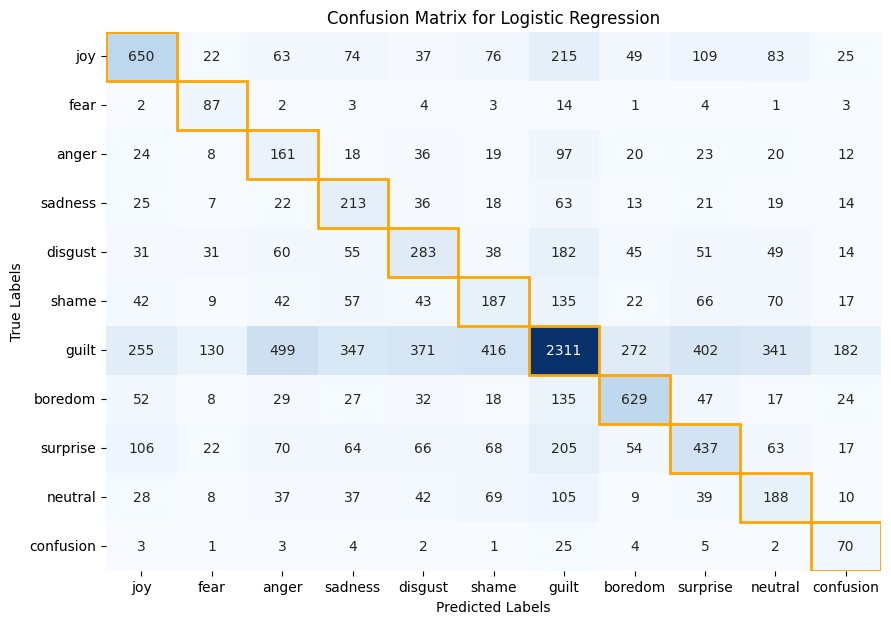


--- Naive Bayes with SMOTE ---
Accuracy: 0.33943171699182384
Classification Report:
               precision    recall  f1-score   support

       anger       0.45      0.40      0.43      1403
     boredom       0.13      0.50      0.21       124
   confusion       0.13      0.39      0.19       438
     disgust       0.21      0.49      0.30       451
        fear       0.26      0.33      0.29       839
       guilt       0.19      0.25      0.22       690
         joy       0.67      0.27      0.39      5526
     neutral       0.48      0.58      0.52      1018
     sadness       0.33      0.33      0.33      1172
       shame       0.20      0.33      0.25       572
    surprise       0.06      0.36      0.10       120

    accuracy                           0.34     12353
   macro avg       0.28      0.38      0.29     12353
weighted avg       0.47      0.34      0.36     12353



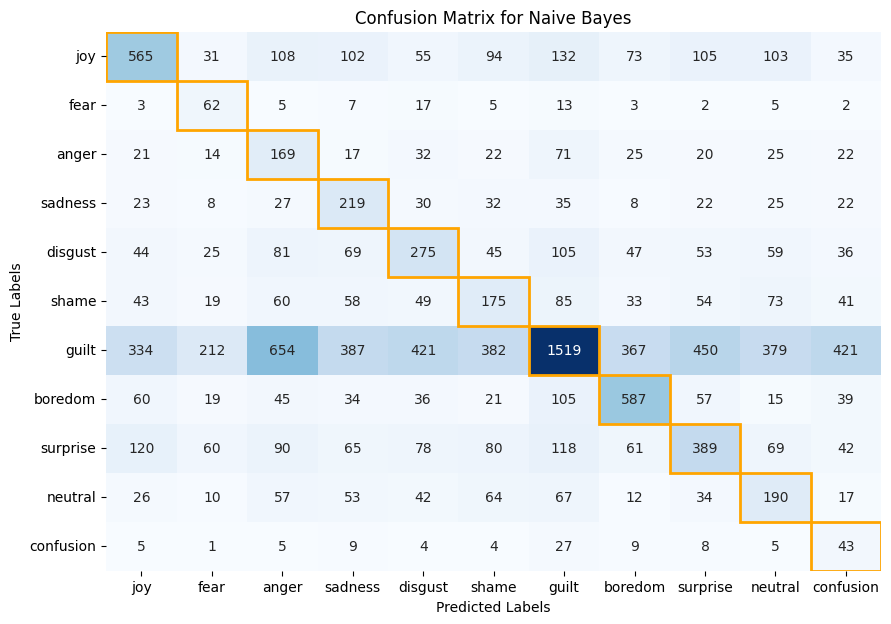


--- Decision Tree with SMOTE ---
Accuracy: 0.43252651177851537
Classification Report:
               precision    recall  f1-score   support

       anger       0.48      0.41      0.44      1403
     boredom       0.31      0.55      0.40       124
   confusion       0.15      0.18      0.16       438
     disgust       0.23      0.26      0.24       451
        fear       0.22      0.22      0.22       839
       guilt       0.19      0.17      0.18       690
         joy       0.59      0.57      0.58      5526
     neutral       0.48      0.50      0.49      1018
     sadness       0.32      0.32      0.32      1172
       shame       0.21      0.22      0.22       572
    surprise       0.19      0.38      0.25       120

    accuracy                           0.43     12353
   macro avg       0.31      0.34      0.32     12353
weighted avg       0.44      0.43      0.44     12353



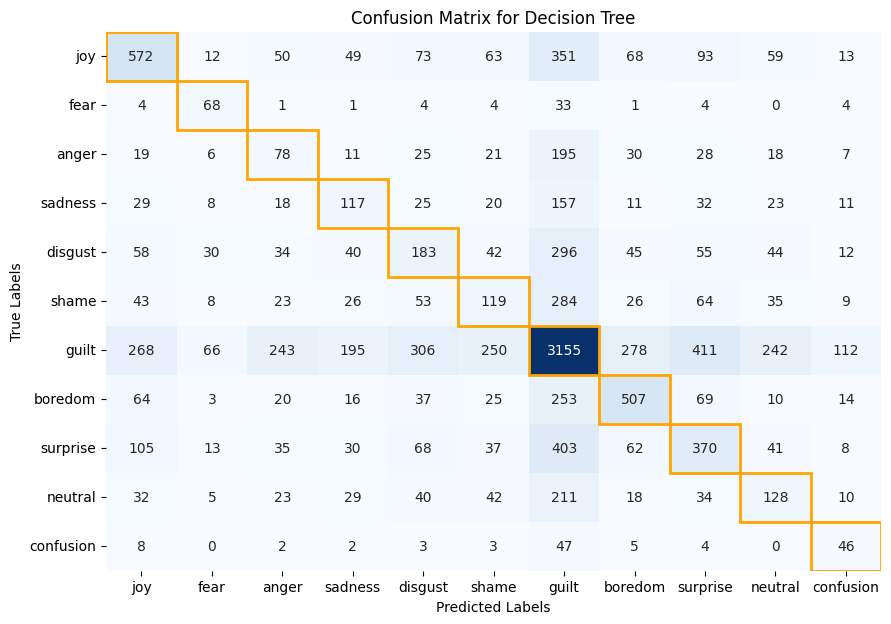


--- Random Forest with SMOTE ---
Accuracy: 0.49437383631506515
Classification Report:
               precision    recall  f1-score   support

       anger       0.57      0.46      0.51      1403
     boredom       0.26      0.59      0.36       124
   confusion       0.18      0.20      0.19       438
     disgust       0.34      0.31      0.32       451
        fear       0.32      0.25      0.28       839
       guilt       0.23      0.21      0.22       690
         joy       0.61      0.65      0.63      5526
     neutral       0.55      0.59      0.57      1018
     sadness       0.41      0.37      0.39      1172
       shame       0.29      0.24      0.26       572
    surprise       0.24      0.42      0.30       120

    accuracy                           0.49     12353
   macro avg       0.36      0.39      0.37     12353
weighted avg       0.49      0.49      0.49     12353



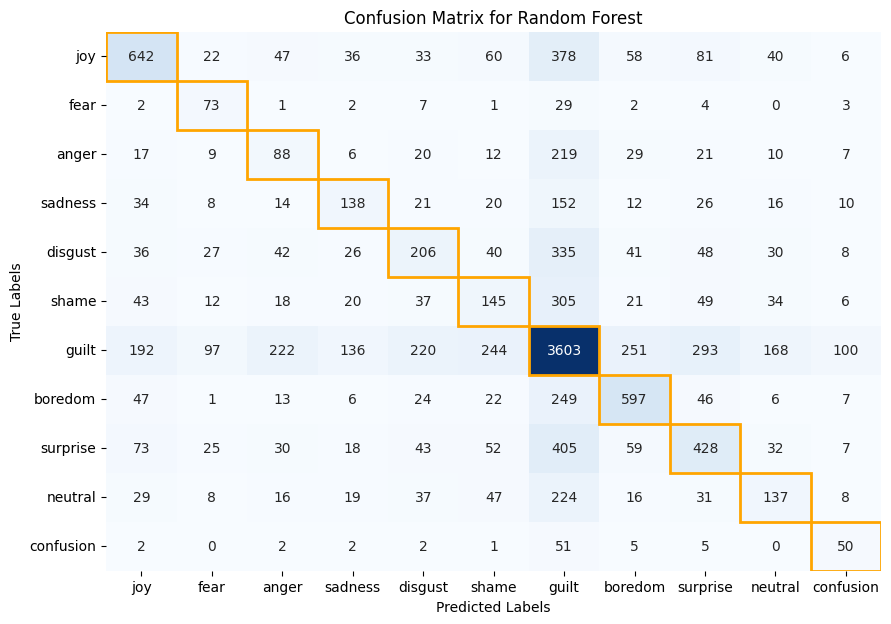

In [10]:
# Initialize models with class weighting
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),  # NB doesn't directly support class_weight; included for comparison
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Dictionary to store accuracy results
accuracy_results = {}

# Evaluate each model
X_resampled, y_resampled = apply_resampling(X_train_tfidf, y_train)

# Evaluate each model on the resampled dataset
for model_name, model in models.items():
    accuracy = evaluate_model(model, X_resampled, y_resampled, X_test_tfidf, y_test, model_name)
    accuracy_results[model_name] = accuracy


# Step 7: Plot Accuracy Results for Each Resampling Technique

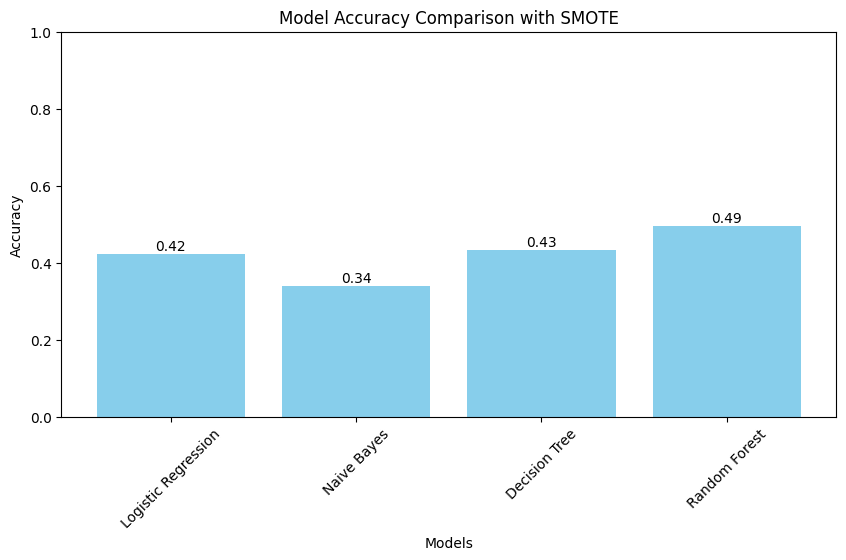

In [11]:
# Plot accuracy comparison
plt.figure(figsize=(10, 5))
plt.bar(accuracy_results.keys(), accuracy_results.values(), color='skyblue')
plt.title('Model Accuracy Comparison with SMOTE')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
# Add accuracy values on top of bars
for i, (model_name, acc) in enumerate(accuracy_results.items()):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center')

plt.show()